# Tutorial to run the pixel implementation with different patches

This tutorial describes how to run the pixel domain implementation of the method with different patches

In [1]:
import os, sys, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import jax
import jax.numpy as jnp
from fgbuster import get_instrument, get_observation, get_noise_realization

import micmac

First, define the problem you want to solve

In [2]:
fgs_model = 'd0s0' # Defining the foreground model

# In case you want to use the customized routines, proceeds as follows 
# you must then define fgs_model_init for the original model from PySM (here with d7s1 as an example) 
# and nside_spv_model for the chosen spatial variatibility of the SEDs 
if fgs_model == 'customized_nonparametric' or fgs_model == 'customized_parametric':
    fgs_model_init = ['s1','d7']
    nside_spv_model = 1
    idx_ref_freq = 6 # Index of the reference frequency in the PySM model ; 6 for 93 GHz in the example of LiteBIRD as it corresponds to the 7th frequency channel


noise_seed = 42 # Define the seed for the noise realization
seed_realization_CMB = 43 # Define the seed for the CMB realization

Then, identify the directories for the param files

In [3]:
dir_params = "example_params/"

# The toml file contain the main parameters for the proper initiliazation of the pipeline
param_toml = dir_params + "corr_cutsky_SO.toml" 

# The yaml file contain spatial variability parameters which are not relevant here, but are needed for the pipeline to run and essential for the pixel pipeline
# Here we choose the nside of the spatial variability to be 1, so 12 patches according the healpix scheme
param_spv_yaml = dir_params + "params_spv_SAT_nside1.yaml" 

Afterwards, create the Pixel sampler from the param files

In [4]:
MICMAC_obj = micmac.create_MICMAC_sampler_from_toml_file(param_toml, path_file_spv=param_spv_yaml)

<_io.TextIOWrapper name='example_params/params_spv_SAT_nside1.yaml' mode='r' encoding='UTF-8'>
count_b: 8
n_betas:  8

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [1]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f2
      default: [1]
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [1]
    f1
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]
    f2
      default: [1]
      b0
        default: [1]
      b1
        default: [1]
      b2
        default: [1]
      b3
        default: [1]


# Generate input maps

Defining the parameters of the problem using **`fgbuster`**

In [5]:
instr_name = MICMAC_obj.instrument_name

# Define the instrument
if MICMAC_obj.instrument_name != 'customized_instrument':
    instrument = get_instrument(MICMAC_obj.instrument_name) # To get the
else:
    with open(path_toml_file) as f:
        dictionary_toml = toml.load(f)
    f.close()
    instrument = micmac.get_instr(MICMAC_obj.frequency_array, dictionary_toml['depth_p'])

# Get input foreground maps

if fgs_model == 'customized_parametric':
    print(f"Taking customized parametric foreground model {fgs_model_init} downgraded to {nside_spv_model}")
    my_sky, _ = micmac.parametric_sky_customized(
        fgs_model_init, 
        MICMAC_obj.nside, 
        nside_spv_model
    )
    freq_maps_fgs_denoised = micmac.get_observation_customized(
        instrument, 
        my_sky, 
        nside=MICMAC_obj.nside, 
        noise=False
    )[:, 1:, :]   # keep only Q and U
elif fgs_model == 'customized_nonparametric':
    print(f"Taking customized nonparametric foreground model {fgs_model_init} downgraded to {nside_spv_model}")
    freq_maps_fgs_denoised, non_param_fgs_SEDs = micmac.fgs_freq_maps_from_customized_model_nonparam(
        MICMAC_obj.nside, 
        nside_spv_model, 
        instrument, 
        fgs_models=fgs_model_init, 
        idx_ref_freq=idx_ref_freq
        )
elif fgs_model != '':
    print(f"Taking PySM foreground model {fgs_model}")
    freq_maps_fgs_denoised = get_observation(
        instrument, 
        fgs_model, 
        nside=MICMAC_obj.nside, 
        noise=False
        )[:, 1:, :]  # keep only Q and U
else:
    print("No foreground model specified")
    freq_maps_fgs_denoised = np.zeros((MICMAC_obj.n_frequencies, MICMAC_obj.nstokes, MICMAC_obj.n_pix)) # No foregrounds


Taking PySM foreground model d0s0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# Get noise maps
np.random.seed(noise_seed)
input_noise_map = get_noise_realization(MICMAC_obj.nside, instrument)[:, 1:, :]

Assemble everything

In [7]:
freq_maps_fgs = freq_maps_fgs_denoised + input_noise_map


Now retrieving the CMB maps and spectra using the r value given in the params files using `CAMB` to generate an input CMB spectrum and `Healpy` to generate the map

In [8]:
np.random.seed(seed_realization_CMB)

input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


- `input_freq_maps` contains CMB+foregrounds+noise
- `input_cmb_maps` only contains CMB (over all frequencies)
- `theoretical_red_cov_r0_total` is the scalar mode spectrum given with dimensions `[lmax+1-lmin, nstokes, nstokes]`
- `theoretical_red_cov_r1_tensor` is the tensor mode spectrum given with dimensions `[lmax+1-lmin, nstokes, nstokes]`

To recover the classic form of the power specturm `[number_correlations,lmax+1-lmin]` from the reduced covariance form with dimensions `[lmax+1-lmin, nstokes, nstokes]`, we can call:

In [9]:
theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

The input covariance can be retrieved as:

In [10]:
input_cmb_power_spectrum = theoretical_r0_total + theoretical_r1_tensor * MICMAC_obj.r_true

## Minimally informed approach

In order to do the minimally informed approach described in [Leloup et al. 2023](https://arxiv.org/abs/2308.03412), we must define a correction term denoted `C_approx`.

In the approach, this can correspond to the scalar mode power spectrum, so we can define it as:

In [11]:
c_ell_approx = np.zeros((MICMAC_obj.n_correlations, MICMAC_obj.lmax+1))

c_ell_approx[:, MICMAC_obj.lmin :] = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

From here, we have almost all the tools to compute the log-proba associated with the problem, we now need to set up the sampling itself.

# First guesses and covariance for the Metropolis-Hastings sampling

We can obtain the B_f covariance and r step-size through Fisher matrices computed prior

In [12]:
ls examples_Fisher_matrices/

Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt
Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt


In [13]:
dir_Fisher = 'examples_Fisher_matrices/'

inverse_covariance_matrix = np.loadtxt(dir_Fisher + 'Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')

MICMAC_obj.covariance_B_f = np.linalg.inv(inverse_covariance_matrix)[:-1, :-1]/100
MICMAC_obj.step_size_r = np.sqrt(np.linalg.inv(inverse_covariance_matrix)[-1, -1])/10

Note that the step_size of each mixing matrix element will be repeated over all patches associated with the same mxixing matrix element

We can compute the exact solutions for $B_f$ (with *d0s0*) from a given parametrisation with $\beta_d$, $T_d$, $\beta_s$

In [14]:
exact_solution_beta_mbb = 1.54
exact_solution_temp_mbb = 20.
exact_solution_beta_pl = -3.

In [15]:
if fgs_model == 'customized_nonparametric':
    init_mixing_matrix_obj = micmac.InitMixingMatrix(
        freqs=MICMAC_obj.frequency_array,
        ncomp=MICMAC_obj.n_components,
        pos_special_freqs=MICMAC_obj.pos_special_freqs,
        spv_nodes_b=MICMAC_obj.spv_nodes_b,
        non_param_fgs_mixing_matrix=non_param_fgs_SEDs,
        beta_mbb=exact_solution_beta_mbb,
        temp_mbb=exact_solution_temp_mbb,
        beta_pl=exact_solution_beta_pl
    )
    theoretical_params = init_mixing_matrix_obj.init_params()
else:
    init_mixing_matrix_obj = micmac.InitMixingMatrix(
        freqs=MICMAC_obj.frequency_array,
        ncomp=MICMAC_obj.n_components,
        pos_special_freqs=MICMAC_obj.pos_special_freqs,
        spv_nodes_b=MICMAC_obj.spv_nodes_b,
        beta_mbb=exact_solution_beta_mbb,
        temp_mbb=exact_solution_temp_mbb,
        beta_pl=exact_solution_beta_pl
    )
    theoretical_params = init_mixing_matrix_obj.init_params()


>>> init params built with spectral params: 1.54 20.0 -3.0


As for r, it can be anything sensible (between $0$ and the current constraint, but not $0$)

The usual approach when considering $r_{\rm true} = 0$ is to set-up a boundary for the $r$ sampling, which is done in the following way

In [16]:
# Getting r_min

## We first define the minimum value of r available to keep C(r) positive definite
new_min_r_value = -np.min(theoretical_red_cov_r0_total[:, 1, 1] / theoretical_red_cov_r1_tensor[:, 1, 1])
MICMAC_obj.min_r_value = new_min_r_value

We can as well prepare a mask to use

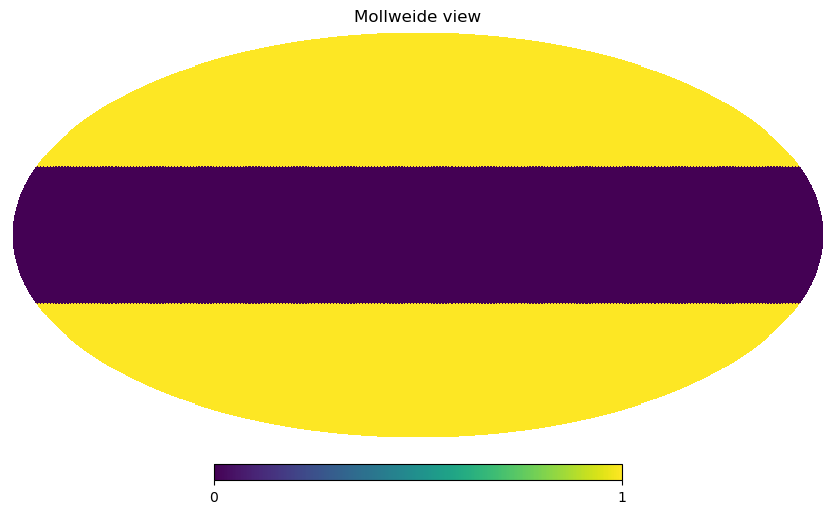

In [17]:
indices = np.arange(MICMAC_obj.n_pix)

ang_to_cut = hp.pix2ang(MICMAC_obj.nside, indices, lonlat=True)

cond = np.bitwise_or(np.bitwise_and(ang_to_cut[1] > 25, ang_to_cut[1] < 90), np.bitwise_and(ang_to_cut[1] > -90, ang_to_cut[1] < -25))

new_pix = hp.ang2pix(
    MICMAC_obj.nside, 
    ang_to_cut[0][cond],
    ang_to_cut[1][cond],
    lonlat=True
)

fake_mask = np.zeros_like(indices)
fake_mask[cond] = 1

hp.mollview(fake_mask)

In [18]:
# Setting up the mask

MICMAC_obj.mask = fake_mask

***We are now fully ready to perform the Gibbs sampling !***

# Gibbs sampling

We first prepare the first guesses

In [19]:
# First guesses preparation
initial_wiener_filter_term = np.zeros((MICMAC_obj.nstokes, MICMAC_obj.n_pix))
initial_fluctuation_maps = np.zeros((MICMAC_obj.nstokes, MICMAC_obj.n_pix))

len_pos_special_freqs = len(MICMAC_obj.pos_special_freqs)
dimension_free_param_B_f = jnp.size(MICMAC_obj.indexes_free_Bf)


In [20]:
gap_to_true_value = 10

In [21]:
initial_guess_r = 1e-8 + np.random.uniform(low=-gap_to_true_value, high=gap_to_true_value, size=1) * MICMAC_obj.step_size_r

# Redefine initial r if negative
if initial_guess_r < 0:
    initial_guess_r = 1e-8 * np.random.uniform(low=0, high=gap_to_true_value, size=1)

In [22]:
CMB_c_ell = np.zeros_like(c_ell_approx)

CMB_c_ell[:, MICMAC_obj.lmin :] = theoretical_r0_total + initial_guess_r * theoretical_r1_tensor


We must also take into account that the first guess of the initial $B_f$ parameters must be given for each patch. In the case where all the patch distributions are identical for each $B_f$, and the patches are distributed according to $HEALPix$ pixelization (here with `nside=1`), then they can be easily expanded as

In [23]:
expand_factor = MICMAC_obj.len_params // theoretical_params.shape[0]

theoretical_params_patch = np.broadcast_to(
        theoretical_params, (expand_factor, theoretical_params.shape[0])
        ).ravel(order='F')
# Note that the broadcast may not copy the values of the initial array, but put the same references in the new array!


# The same can be applied to the step size you may use to generate random initial values
step_size_B_f = np.diag(sp.linalg.sqrtm(MICMAC_obj.covariance_B_f))

expand_factor_step_size = MICMAC_obj.len_params // step_size_B_f.shape[0]


step_size_B_f_patch = np.broadcast_to(
        step_size_B_f, (expand_factor_step_size, step_size_B_f.shape[0])
        ).ravel(order='F')

In [24]:

init_params_mixing_matrix_patch = theoretical_params_patch + step_size_B_f_patch * gap_to_true_value * np.random.randn(theoretical_params_patch.size)

We can change here the number of iterations of the Metropolis-Hastings, otherwise the one by default in the parameter file will be chosen

In [25]:
MICMAC_obj.number_iterations_sampling = 10

In [26]:
# Getting N
freq_inverse_noise = micmac.get_noise_covar_extended(np.array(instrument['depth_p']), MICMAC_obj.nside)

# Setting up the mask for the noise covariance 
MICMAC_obj.freq_inverse_noise = freq_inverse_noise * MICMAC_obj.mask


# Setting up the mask for the input data
input_freq_maps_masked = input_freq_maps * MICMAC_obj.mask 

When using the patches, you absolutely must make sure those booleans are set to `True` otherwise the routine will be significantly slower

In [27]:
# To compute difference between CMB noise covariance for eta log proba instead of repeating the CG for each B_f sampling
MICMAC_obj.perturbation_eta_covariance = True

# To compute the acceptance rate in parallel for patches in the B_f sampling, default False
MICMAC_obj.simultaneous_accept_rate = True

Then we can run the sampling itself

In [28]:
%%time
time_start_sampling = time.time()
MICMAC_obj.perform_Gibbs_sampling(
    input_freq_maps_masked,
    c_ell_approx,
    CMB_c_ell,
    init_params_mixing_matrix_patch,
    initial_guess_r=initial_guess_r,
    initial_wiener_filter_term=initial_wiener_filter_term,
    initial_fluctuation_maps=initial_fluctuation_maps,
    theoretical_r0_total=theoretical_r0_total,
    theoretical_r1_tensor=theoretical_r1_tensor,
)
time_full_chain = (time.time() - time_start_sampling) / 60


Disabling chex !!!
Sampling r from BB !!!
Using biased version or perturbation version of mixing matrix sampling !!!
Using full_sky correction !!!
Using simultaneous accept rate version of mixing matrix sampling !!!
---- ATTENTION: This assumes all patches are distributed in the same way for all parameters !
Previous free indexes for B_f [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] 96
New free indexes for B_f [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] 96
Step-size B_f [1.22719235e-05 4.72984090e-0

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2073: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


Starting 10 iterations from 0 iterations done
Recalculating x !
Recalculating y !
CG-Inverse term eta finished in  0.16863489151000977  seconds with  None  iterations
CG WF finished with None iterations in  0.16304898262023926 seconds !!
Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  0.3069911003112793 seconds !!


  0%|          | 0/10 [00:00<?, ?it/s]

End of iterations in 3.384644265969594 minutes, saving all files !
End of updating in 0.002445069948832194 minutes
Last key PRNG [4046737378 1557832356]
CPU times: user 18min 8s, sys: 1min 52s, total: 20min
Wall time: 3min 25s


We can then retrieve the chains, which will be in the format [number_iterations+1, size_sample]

In [29]:
all_params_mixing_matrix_samples = MICMAC_obj.all_params_mixing_matrix_samples
all_r_samples = MICMAC_obj.all_samples_r

And finally plot the parameters, starting with $r$:

In [30]:
expected_burn_in = 0 # To be fine-tuned

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


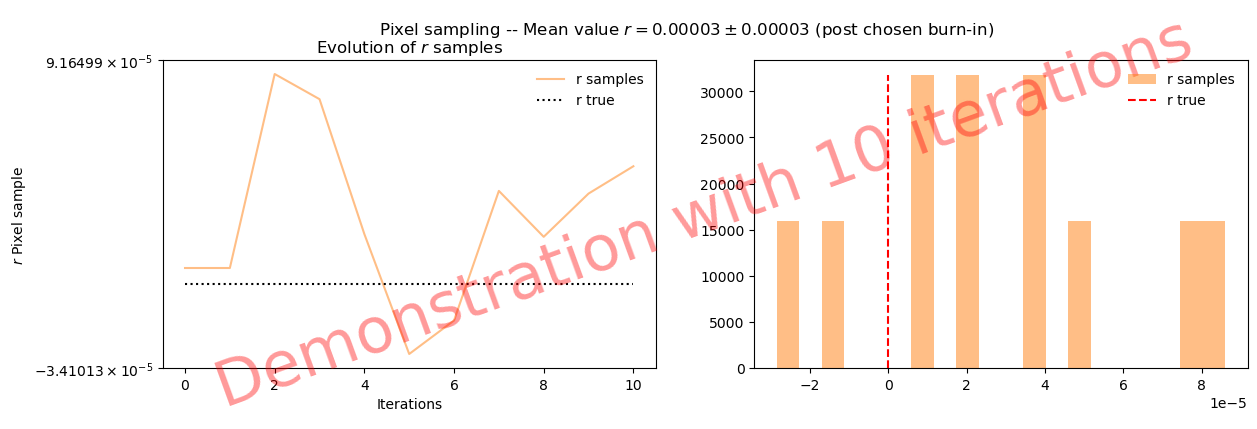

In [31]:
# plt.figure(figsize=(14,4))

# n_sigma = 3

all_r_samples = MICMAC_obj.all_samples_r

cond = np.arange(MICMAC_obj.number_iterations_sampling+1) >= expected_burn_in
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

alpha_value = .5

fig, ax = plt.subplots(1, 2, figsize=(14,4))

plt.suptitle("Pixel sampling -- Mean value $r = {:.5f} \pm {:.5f}$ (post chosen burn-in) ".format(mean_r, std_r))

# plt.subplot(121)
ax[0].plot(np.arange(MICMAC_obj.number_iterations_sampling+1), all_r_samples, color='tab:orange', label='r samples', alpha=0.5)
ax[0].plot([0, MICMAC_obj.number_iterations_sampling], [MICMAC_obj.r_true,MICMAC_obj.r_true], 'k:', label='r true')


ax[0].set_xlabel("Iterations")
ax[0].set_ylabel('$r$ Pixel sample')
ax[0].set_title(r'Evolution of $r$ samples')
if MICMAC_obj.r_true >= 0:
    ax[0].set_yscale('symlog')
else:
    ax[0].set_yscale('log')
ax[0].legend(frameon=False)

# plt.subplot(122)
hist_values, bins_value, _ = ax[1].hist(all_r_samples, bins=20, label='r samples', color='tab:orange', density=True, alpha=0.5)
ax[1].plot([MICMAC_obj.r_true,MICMAC_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
ax[1].legend(frameon=False)

ax[1].text(-0.1, 0.5, 'Demonstration with 10 iterations', transform=ax[1].transAxes,
        fontsize=45, color='red', alpha=0.4,
        ha='center', va='center', rotation=20)

plt.show()

Then $\bf B_f$

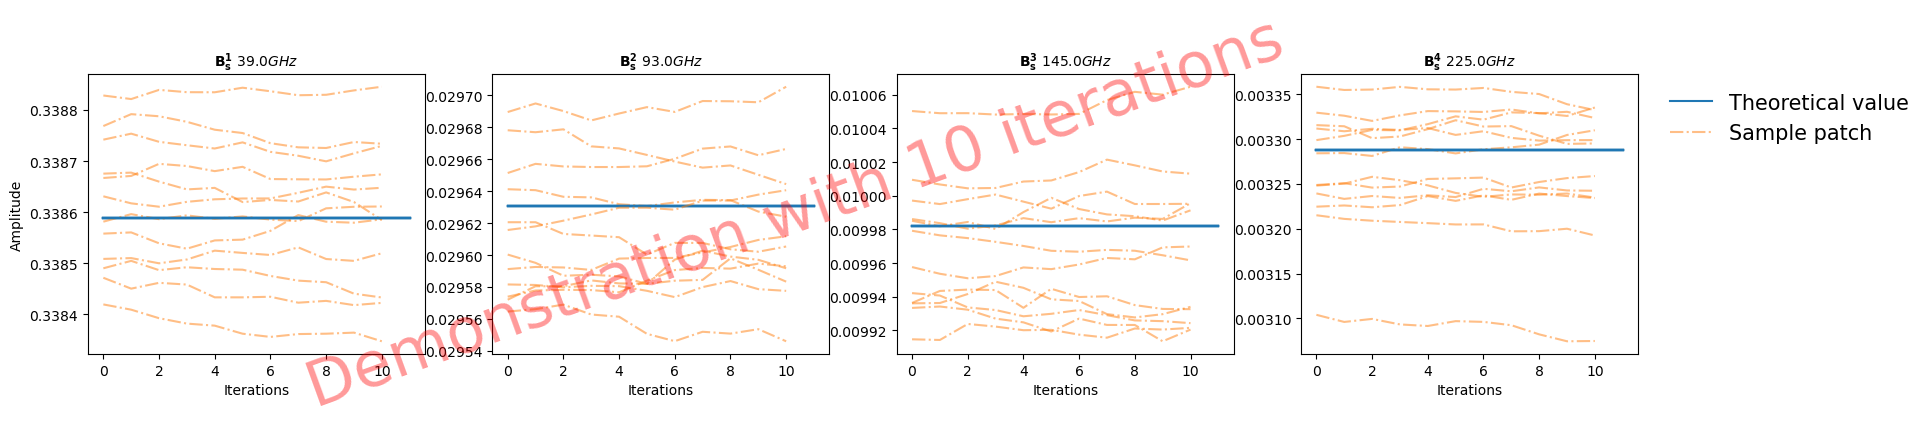

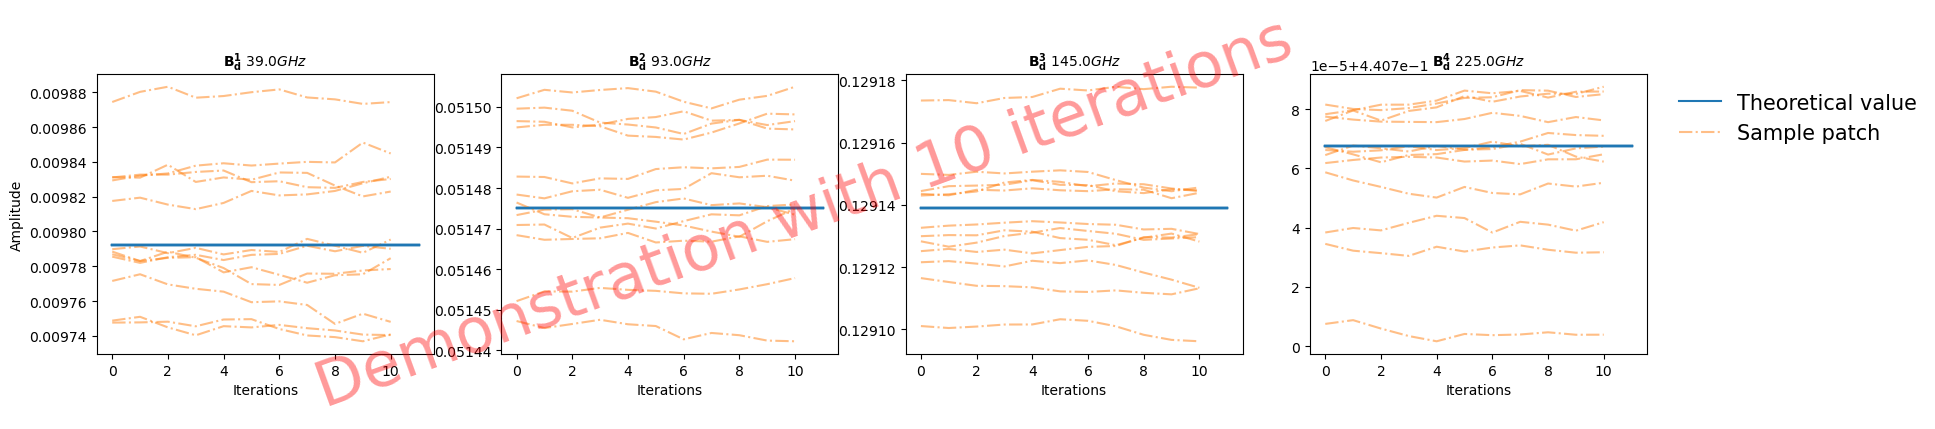

In [33]:
list_correl = ['EE', 'BB', 'EB']

red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)
ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = len(frequency_Bf)
dim_synch = MICMAC_obj.indexes_b[0,1]
len_pos_special_freqs = len(MICMAC_obj.pos_special_freqs)

number_params_synch = MICMAC_obj.indexes_b[0,1]

all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:number_params_synch]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,number_params_synch:]

frequency_array = np.array(instrument['frequency'])

n_columns = 4
number_rows = (MICMAC_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

fontsize_titles = 10
fontsize_label = 10

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title('$\mathbf{B_s^{'+f'{i+1}'+'}\ }$' + f'${frequency_Bf[i]} GHz$', fontsize=fontsize_titles, fontdict=dict(weight='bold'))
    
    indices_to_plot = MICMAC_obj.indexes_b[i,0] + np.arange(MICMAC_obj.size_patches[i])
    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_obj.indexes_free_Bf)]
    
    ax[num_row, num_col].plot([0,MICMAC_obj.number_iterations_sampling+1], [theoretical_params[indices_to_plot[0]],theoretical_params[indices_to_plot[0]]], label='Theoretical value')
    ax[num_row, num_col].plot(np.arange(MICMAC_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[:,MICMAC_obj.indexes_b[i,0]], '-.', color='tab:orange', alpha=alpha_value, label='Sample patch')

    for j in indices_to_plot[1:]:
        ax[num_row, num_col].plot([0,MICMAC_obj.number_iterations_sampling+1], [theoretical_params[j],theoretical_params[j]], color='tab:blue')
        ax[num_row, num_col].plot(np.arange(MICMAC_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[:,j], '-.', color='tab:orange', alpha=alpha_value)

    cond = np.where(np.arange(MICMAC_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_synch[cond,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_synch[cond,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_synch[:,i].mean()

    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude', fontsize=fontsize_label)
    if i >= MICMAC_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations', fontsize=fontsize_label)
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=45, color='red', alpha=0.4,
        ha='center', va='center', rotation=20)


fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    # ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
    ax[num_row, num_col].set_title('$\mathbf{B_d^{'+f'{i+1}'+'}\ }$' + f'${frequency_Bf[i]} GHz$', fontsize=fontsize_titles, fontdict=dict(weight='bold'))
    
    indices_to_plot = MICMAC_obj.indexes_b[i,1] + np.arange(MICMAC_obj.size_patches[i+number_params_synch])
    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_obj.indexes_free_Bf)]
    
    ax[num_row, num_col].plot([0,MICMAC_obj.number_iterations_sampling+1], [theoretical_params[indices_to_plot[0]],theoretical_params[indices_to_plot[0]]], label='Theoretical value')
    ax[num_row, num_col].plot(np.arange(MICMAC_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[:,indices_to_plot[0]], '-.', color='tab:orange', alpha=alpha_value, label='Sample patch')

    for j in indices_to_plot[1:]:
        ax[num_row, num_col].plot([0,MICMAC_obj.number_iterations_sampling+1], [theoretical_params[j],theoretical_params[j]], color='tab:blue')
        ax[num_row, num_col].plot(np.arange(MICMAC_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[:,j], '-.', color='tab:orange', alpha=alpha_value)
    

    cond = np.where(np.arange(MICMAC_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_dust[cond,i].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_dust[cond,i].std(), decimals=5)

    mean_value = all_B_f_sample_dust[:,i].mean()
    # ax[num_row, num_col].plot([0,MICMAC_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')
    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude', fontsize=fontsize_label)
    if i >= MICMAC_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations', fontsize=fontsize_label)
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=45, color='red', alpha=0.4,
        ha='center', va='center', rotation=20)

plt.show()

And the corresponding histograms, a good test to check if the distribution is Gaussian or not

In [34]:
burn_in = -30000 # To be fine-tuned

bins_number = 25

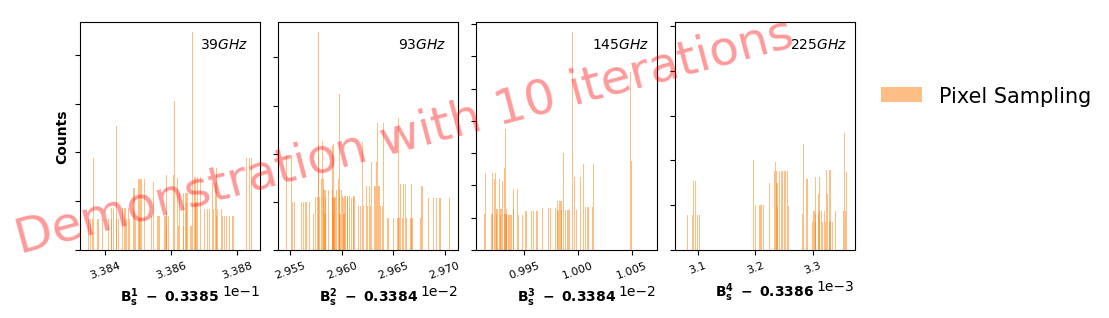

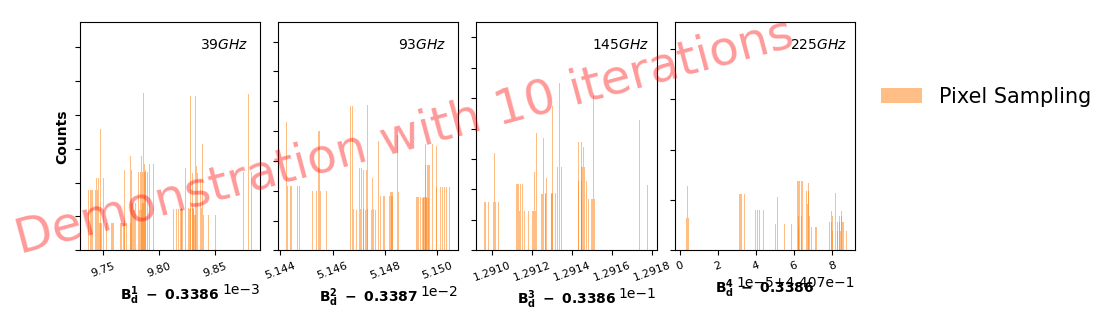

In [35]:
list_correl = ['EE', 'BB', 'EB']

frequency_Bf = np.array(MICMAC_obj.frequency_array[1:-1])
dimension_free_param_B_f = 2*(MICMAC_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
Harm_color = ['tab:orange']

fontsize_titles = 10
fontsize_label = 10

mean_Harm_synch = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f].mean(axis=0)
mean_Harm_dust = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:].mean(axis=0)

all_B_f_sample_synch = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f] - mean_Harm_synch
all_B_f_sample_dust = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:] - mean_Harm_dust


frequency_array = np.array(MICMAC_obj.frequency_array)

number_columns = 4
number_rows = (MICMAC_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

fig, ax = plt.subplots(number_rows, number_columns, figsize=(10,8))
plt.subplots_adjust(hspace=.7, wspace=.1)
useless_plots = number_rows*number_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*number_columns)//number_columns
    num_col = (number_rows*number_columns)%number_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//number_columns
    num_col = i%number_columns
    ax[num_row, num_col].text(.8, .9, f'${frequency_Bf[i]} GHz$', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            fontsize=fontsize_titles, 
                            transform=ax[num_row, num_col].transAxes)
    ax[num_row, num_col].xaxis.set_tick_params(labelsize=8)
    ax[num_row, num_col].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    plt.setp(ax[num_row, num_col].get_xticklabels(), rotation=20, horizontalalignment='center')
    
    indices_to_plot = MICMAC_obj.indexes_b[i,0] + np.arange(MICMAC_obj.size_patches[i])
    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_obj.indexes_free_Bf)]
    
    hist_values, bins_value, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples[:,MICMAC_obj.indexes_b[i,0]], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value, label='Pixel Sampling')

    for j in indices_to_plot[1:]:
        hist_values, bins_value, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples[:,j], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value)

    if num_col == 0:
        ax[num_row, num_col].set_ylabel('Counts', fontsize=fontsize_label, fontdict=dict(weight='bold'))
    ax[num_row, num_col].tick_params(axis='y', labelleft=False)
    
    ax[num_row, num_col].set_xlabel('$\mathbf{B_s^{'+f'{i+1}'+'}\ -}$'+' {:.4f}'.format(mean_Harm_synch[i]), fontsize=fontsize_label, fontdict=dict(weight='bold'))
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()
ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=35, color='red', alpha=0.4,
        ha='center', va='center', rotation=15)

fig, ax = plt.subplots(number_rows, number_columns, figsize=(10,8))
plt.subplots_adjust(hspace=.7, wspace=.1)
useless_plots = number_rows*number_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*number_columns)//number_columns
    num_col = (number_rows*number_columns)%number_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//number_columns
    num_col = i%number_columns
    ax[num_row, num_col].text(.8, .9, f'${frequency_Bf[i]} GHz$', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            fontsize=fontsize_titles, 
                            transform=ax[num_row, num_col].transAxes)
    ax[num_row, num_col].xaxis.set_tick_params(labelsize=8)
    ax[num_row, num_col].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    plt.setp(ax[num_row, num_col].get_xticklabels(), rotation=20, horizontalalignment='center')

    indices_to_plot = MICMAC_obj.indexes_b[i,1] + np.arange(MICMAC_obj.size_patches[i+number_params_synch])
    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_obj.indexes_free_Bf)]
    
    hist_values, bins_value, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples[:,indices_to_plot[0]], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value, label='Pixel Sampling')
    
    for j in indices_to_plot[1:]:
        hist_values, bins_value, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples[:,j], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value)
    
    if num_col == 0:
        ax[num_row, num_col].set_ylabel('Counts', fontsize=fontsize_label, fontdict=dict(weight='bold'))
    ax[num_row, num_col].tick_params(axis='y', labelleft=False)

    ax[num_row, num_col].set_xlabel('$\mathbf{B_d^{'+f'{i+1}'+'}\ -} $'+' {:.4f}'.format(mean_Harm_dust[i]), fontsize=fontsize_label, fontweight='bold')
    
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()
ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=35, color='red', alpha=0.4,
        ha='center', va='center', rotation=15)
plt.show()

Here is another example of the possible view of the distribution of values for the patches

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


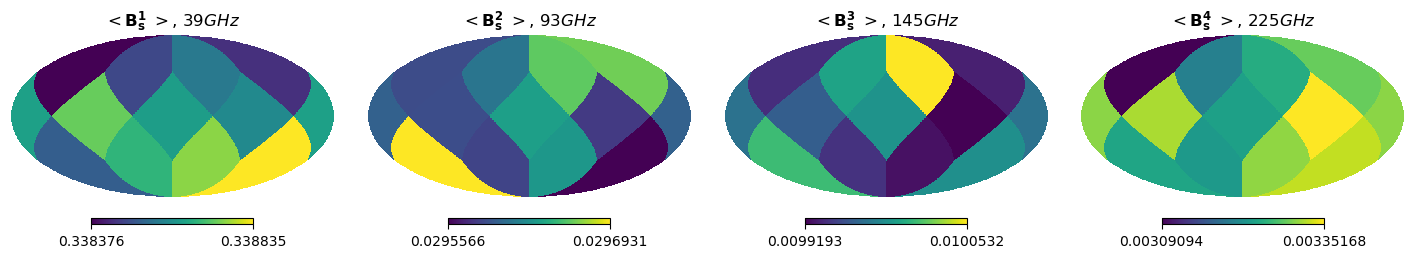

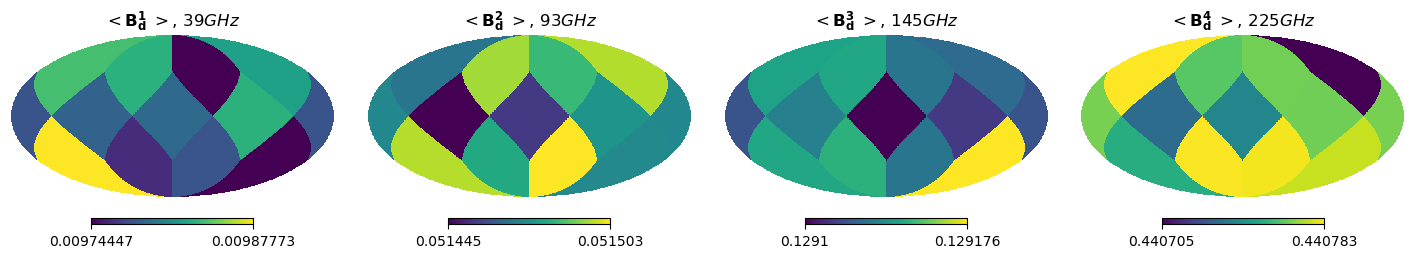

In [36]:
list_correl = ['EE', 'BB', 'EB']

frequency_Bf = np.array(MICMAC_obj.frequency_array[1:-1])
dimension_free_param_B_f = 2*(MICMAC_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
Harm_color = ['tab:orange']

fontsize_titles = 10
fontsize_label = 10

mean_Harm_synch = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f].mean(axis=0)
mean_Harm_dust = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:].mean(axis=0)

all_B_f_sample_synch = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f] - mean_Harm_synch
all_B_f_sample_dust = MICMAC_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:] - mean_Harm_dust


frequency_array = np.array(MICMAC_obj.frequency_array)

number_columns = 4
number_rows = (MICMAC_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

fig, ax = plt.subplots(number_rows, number_columns, figsize=(18,14))
plt.subplots_adjust(hspace=.7, wspace=.1)
useless_plots = number_rows*number_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*number_columns)//number_columns
    num_col = (number_rows*number_columns)%number_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//number_columns
    num_col = i%number_columns
    plt.subplot(number_rows, number_columns, i+1)

    indices_to_plot = MICMAC_obj.indexes_b[i,0] + np.arange(MICMAC_obj.size_patches[i])

    hp.mollview(all_params_mixing_matrix_samples[burn_in:,indices_to_plot].mean(axis=0), hold=True, title='$<\mathbf{B_s^{'+f'{i+1}'+'}\ }>$' + f', ${frequency_Bf[i]} GHz$')


ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()
ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=35, color='red', alpha=0.4,
        ha='center', va='center', rotation=15)

fig, ax = plt.subplots(number_rows, number_columns, figsize=(18,14))
plt.subplots_adjust(hspace=.7, wspace=.1)
useless_plots = number_rows*number_columns - (MICMAC_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*number_columns)//number_columns
    num_col = (number_rows*number_columns)%number_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(MICMAC_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//number_columns
    num_col = i%number_columns
    plt.subplot(number_rows, number_columns, i+1)

    indices_to_plot = MICMAC_obj.indexes_b[i,1] + np.arange(MICMAC_obj.size_patches[i+number_params_synch])

    hp.mollview(all_params_mixing_matrix_samples[burn_in:,indices_to_plot].mean(axis=0), hold=True, title='$<\mathbf{B_d^{'+f'{i+1}'+'}\ }>$' + f', ${frequency_Bf[i]} GHz$')
    
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()
ax[0,n_columns-1].text(-1.5, 0.5, 'Demonstration with 10 iterations', transform=ax[0,n_columns-1].transAxes,
        fontsize=35, color='red', alpha=0.4,
        ha='center', va='center', rotation=15)
plt.show()

The final values will be given by the average of the chains

In [37]:
last_samples_to_take = 10000 # Last samples to take for the mean and std computation -- To fine-tune

# Getting <B_f>
final_B_f = all_params_mixing_matrix_samples[-last_samples_to_take:,:].mean(axis=0)

# Getting <r>
final_r = all_r_samples[-last_samples_to_take:].mean()

Then we can plot the corresponding residuals

In [38]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total + MICMAC_obj.r_true*theoretical_red_cov_r1_tensor)
c_ell_CMB_r2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total + 0.01*theoretical_red_cov_r1_tensor)
c_ell_lensing = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total)

In [39]:

mean_params_list = [final_B_f]
method_name = ['Pixel']


Values pixel res fgs: mean 0.0006374008087877825 std 0.0011413262440592657 max 0.014965001758689311


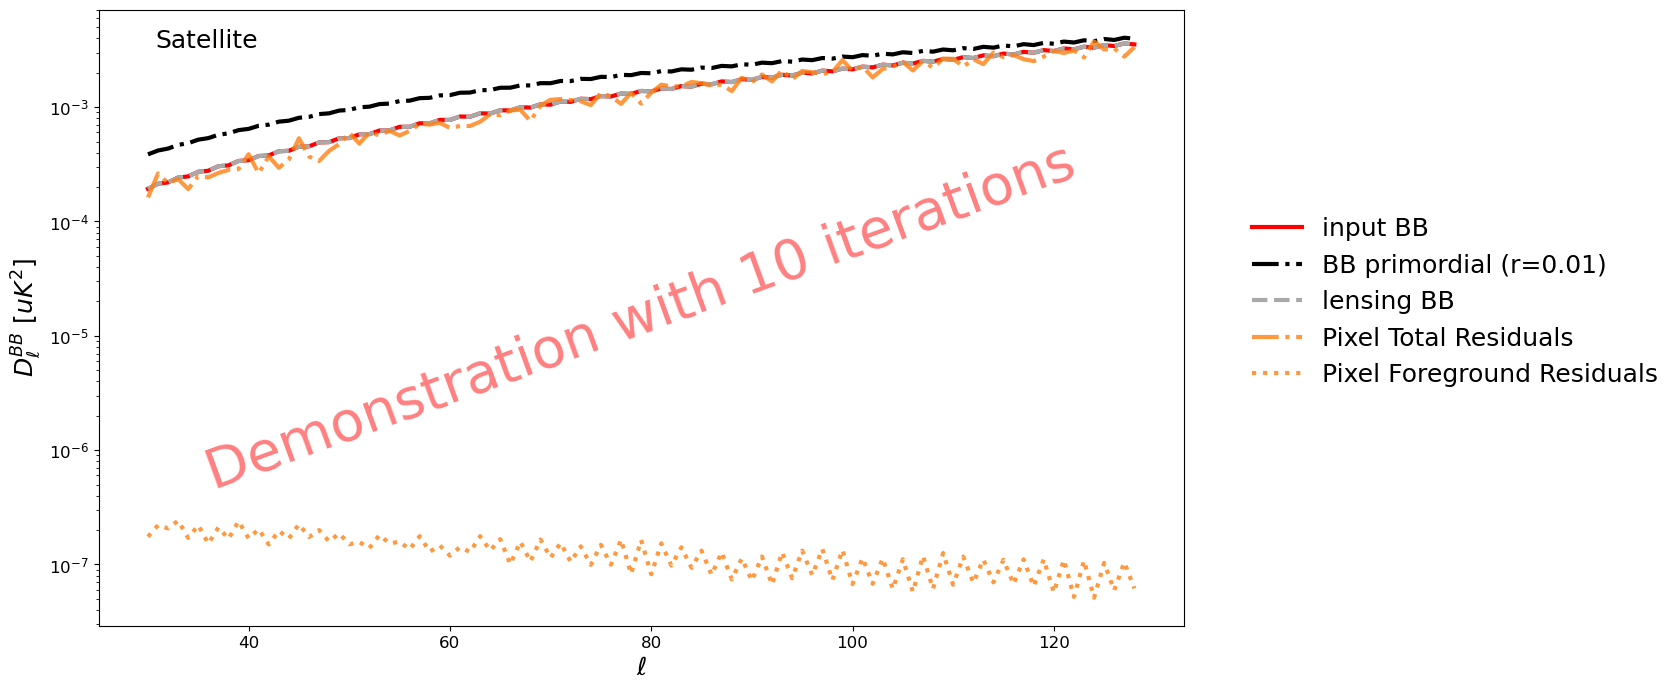

In [40]:
# Residuals power spectrum


colorstyle_list = ['tab:orange','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

indices_polar = np.array([1,2,4])

linewidth_plots = 3

fig, axes = plt.subplots(figsize=(14,8))

ell_array = np.arange(MICMAC_obj.lmin, MICMAC_obj.lmax+1)

# Plotting as D_ell = ell*(ell+1)/(2*pi) C_ell
factor_ell = (ell_array*(ell_array+1))/(2*np.pi)

# Plotting the CMB power spectra for reference
plt.plot(ell_array, c_ell_true_CMB[1,:]*factor_ell, color='red', linewidth=linewidth_plots, label='input BB')
plt.plot(ell_array, c_ell_CMB_r2[1,:]*factor_ell, 'k-.', linewidth=linewidth_plots, label='BB primordial (r=0.01)')
plt.plot(ell_array, c_ell_lensing[1,:]*factor_ell, '--', color='darkgray', linewidth=linewidth_plots, label='lensing BB')


# Getting the residuals
for i in range(len(mean_params_list)):
    mean_mixing_matrix = MICMAC_obj.get_B_from_params(mean_params_list[i])
    recovered_CMB_Wd_mean = micmac.get_Wd(freq_inverse_noise, 
                                            mean_mixing_matrix, 
                                            (input_freq_maps-input_cmb_maps-input_noise_map), 
                                            jax_use=False)[0, :, :]
    print("Values pixel res fgs: mean", np.abs(recovered_CMB_Wd_mean).mean(), "std", np.abs(recovered_CMB_Wd_mean).std(), "max", np.abs(recovered_CMB_Wd_mean).max())

    recovered_res_wo_CMB_mean = micmac.get_Wd(freq_inverse_noise, 
                                                mean_mixing_matrix, 
                                                input_freq_maps, 
                                                jax_use=False)[0, :, :] - input_cmb_maps[0]
    recovered_CMB_Wd_mean_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_mean[0]), recovered_CMB_Wd_mean])
    c_ells_recovered_CMB_Wd_mean = hp.anafast(recovered_CMB_Wd_mean_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)[2,MICMAC_obj.lmin:]#/f_sky
    recovered_res_wo_CMB_mean_extended = np.vstack([np.zeros_like(recovered_res_wo_CMB_mean[0]), recovered_res_wo_CMB_mean])
    c_ells_recovered_res_wo_CMB_mean = hp.anafast(recovered_res_wo_CMB_mean_extended, lmax=MICMAC_obj.lmax, iter=MICMAC_obj.n_iter)[2,MICMAC_obj.lmin:]#/f_sky

    ell_array = np.arange(c_ells_recovered_CMB_Wd_mean.shape[-1])+MICMAC_obj.lmin

    factor_ell = (ell_array*(ell_array+1))/(2*np.pi)


    label_Stat_res = f"{method_name[i]} Total Residuals"
    label_Syst_res = f'{method_name[i]} Foreground Residuals'

    linestyle_dashdotted = '-.'

    plt.plot(ell_array, 
                c_ells_recovered_res_wo_CMB_mean*factor_ell,
                linestyle=linestyle_dashdotted,
                linewidth=linewidth_plots,
                color=colorstyle_list[i], 
                label=label_Stat_res, alpha=.8)

    linestyle_dotted = ':'

    plt.plot(ell_array, 
                c_ells_recovered_CMB_Wd_mean*factor_ell, 
                linestyle=linestyle_dotted,
                linewidth=linewidth_plots, 
                color=colorstyle_list[i], 
                label=label_Syst_res, alpha=.8)

if MICMAC_obj.instrument_name == 'LiteBIRD':
    plt.loglog()
else:
    plt.yscale('log')

plt.ylabel("$D^{BB}_\ell$ [$uK^2$]",fontsize=18)
plt.xlabel(r"$\ell$",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Cosmetic putting "Satellite" in the top left corner
plt.text(.1, .95, 'Satellite', 
                        horizontalalignment='center', 
                        verticalalignment='center', 
                        fontsize=18, 
                        transform=axes.transAxes)


axes.text(0.5, 0.5, 'Demonstration with 10 iterations', transform=axes.transAxes,
        fontsize=40, color='red', alpha=0.5,
        ha='center', va='center', rotation=20)

plt.legend(bbox_to_anchor=(1.25, .7), loc='upper center', prop={'size': 18}, frameon=False)
plt.show()


In this demonstration, the starting point is very close to the actual value the routine is supposed to find, which is why the residuals shown are already very good after 10 iterations.

You should however expect to make few thousands of iterations to properly sample the likelihood, and in particular verify the shape of the histogram is Gaussian.